# **1. Environment setup**

In [3]:
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor

# **2. Helper Functions**

In [6]:
# Helper function to claculate the mode metrics
def calculate_metrics(y_true, y_pred, dataset_type="Dataset"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_type} Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}\n")
    return mse, rmse, mae, r2

# Helper function to plot the most important 10 features
def plot_feature_importance(feature_importances, feature_names, top_n=10, model_name="Model"):
    """Plot the top_n feature importances."""
    top_features = feature_importances[:top_n]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f"Top {top_n} Feature Importances ({model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Helper fuinction to plotScatter Actual vs Predicted values
def plot_actual_vs_predicted(y_test, y_pred_test, title="Actual vs Predicted Retail Price (Test Data)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.6, color='b')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Actual Retail Price")
    plt.ylabel("Predicted Retail Price")
    plt.tight_layout()
    plt.show()

# Helper functions to Plot residuals for training and testing datasets.
def plot_residuals(y_pred_train, y_train, y_pred_test, y_test, model_name="Model"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_train, y_train - y_pred_train, alpha=0.6, color="blue", label="Train")
    plt.hlines(y=0, xmin=min(y_pred_train.min(), y_pred_test.min()), xmax=max(y_pred_train.max(), y_pred_test.max()), color="red", linestyle="--")
    plt.title(f"Residuals Plot - Training ({model_name})")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.6, color="green", label="Test")
    plt.hlines(y=0, xmin=min(y_pred_train.min(), y_pred_test.min()), xmax=max(y_pred_train.max(), y_pred_test.max()), color="red", linestyle="--")
    plt.title(f"Residuals Plot - Testing ({model_name})")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Helper function to plot partial dependence of the top features
def plot_partial_dependence_custom(best_model, X_train, top_features, model_name="Model"):
    """Plot Partial Dependence Plots for the top features."""
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,
        features=top_features,
        grid_resolution=50
    )
    plt.suptitle(f'Partial Dependence Plots for Top Features ({model_name})', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.show()
# Helper function to plot Plot permutation importances
def plot_permutation_importance(result, feature_names, model_name="Model"):
    sorted_idx = result.importances_mean.argsort()
    plt.figure(figsize=(10, 8))
    plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
    plt.title(f'{model_name} Permutation Importances (Test Set)')
    plt.tight_layout()
    plt.show()



# **3. Exploratory Data Analysis (EDA)**

In [8]:
file_path = 'Laptop_Price_Online_Cleaned.csv' # Loading the data set
df = pd.read_csv(file_path)

print("Initial Data Shape:", df.shape)
display(df.head())

# Check percentage of missing values
total_missing = df.isnull().sum().sum()
total_elements = df.size
missing_percentage = (total_missing / total_elements) * 100
print(f"Total Missing Values: {total_missing} ({missing_percentage:.2f}%)")

# Missing values per column
missing_values = df.isnull().mean() * 100
missing_summary = pd.DataFrame({
    'Missing Value (%)': missing_values.round(2),
    'Data Type': df.dtypes
})
print("\nMissing Values per Column:")
display(missing_summary)

Initial Data Shape: (6492, 26)


,Manufacturer,Retail Price,Average Rating,Total Ratings,Product Condition,CPU,Display Size,Color,RAM Size (GB),SSD Storage (GB),...,HDD Capacity (GB),Country of Manufacture,Storage Type,CPU Brand,bluetooth,wi-fi,built-in microphone,touchscreen,backlit keyboard,built-in webcam
0,Chuwi,303.68,NaN,NaN,New,NaN,14.0,Gray,8.0,1.0,...,512.0,China,SSD,NaN,False,False,True,False,True,True
1,Dell,517.49,NaN,NaN,Very Good - Refurbished,Intel Core I7 8Th Gen,14.0,Black,NaN,NaN,...,2000.0,NaN,SSD,Intel,True,True,True,False,True,True
2,Dell,175.00,NaN,NaN,New,Intel Core I5 6Th Gen,14.0,Black,16.0,500.0,...,500.0,China,SSD,Intel,True,True,True,True,True,True
3,Hp,84.99,NaN,NaN,Good - Refurbished,Intel Celeron N,11.6,Black,4.0,NaN,...,16.0,NaN,eMMC,Intel,True,True,True,False,False,True
4,Dell,101.22,NaN,NaN,Good - Refurbished,Intel Core I5 6Th Gen,NaN,NaN,8.0,256.0,...,NaN,NaN,SSD,Intel,False,True,True,False,False,True


Total Missing Values: 78646 (46.59%)

Missing Values per Column:


,Missing Value (%),Data Type
Manufacturer,39.26,object
Retail Price,0.00,float64
Average Rating,95.59,float64
Total Ratings,95.59,float64
Product Condition,7.52,object
CPU,49.83,object
Display Size,65.85,float64
Color,67.10,object
RAM Size (GB),69.15,float64
SSD Storage (GB),57.72,float64


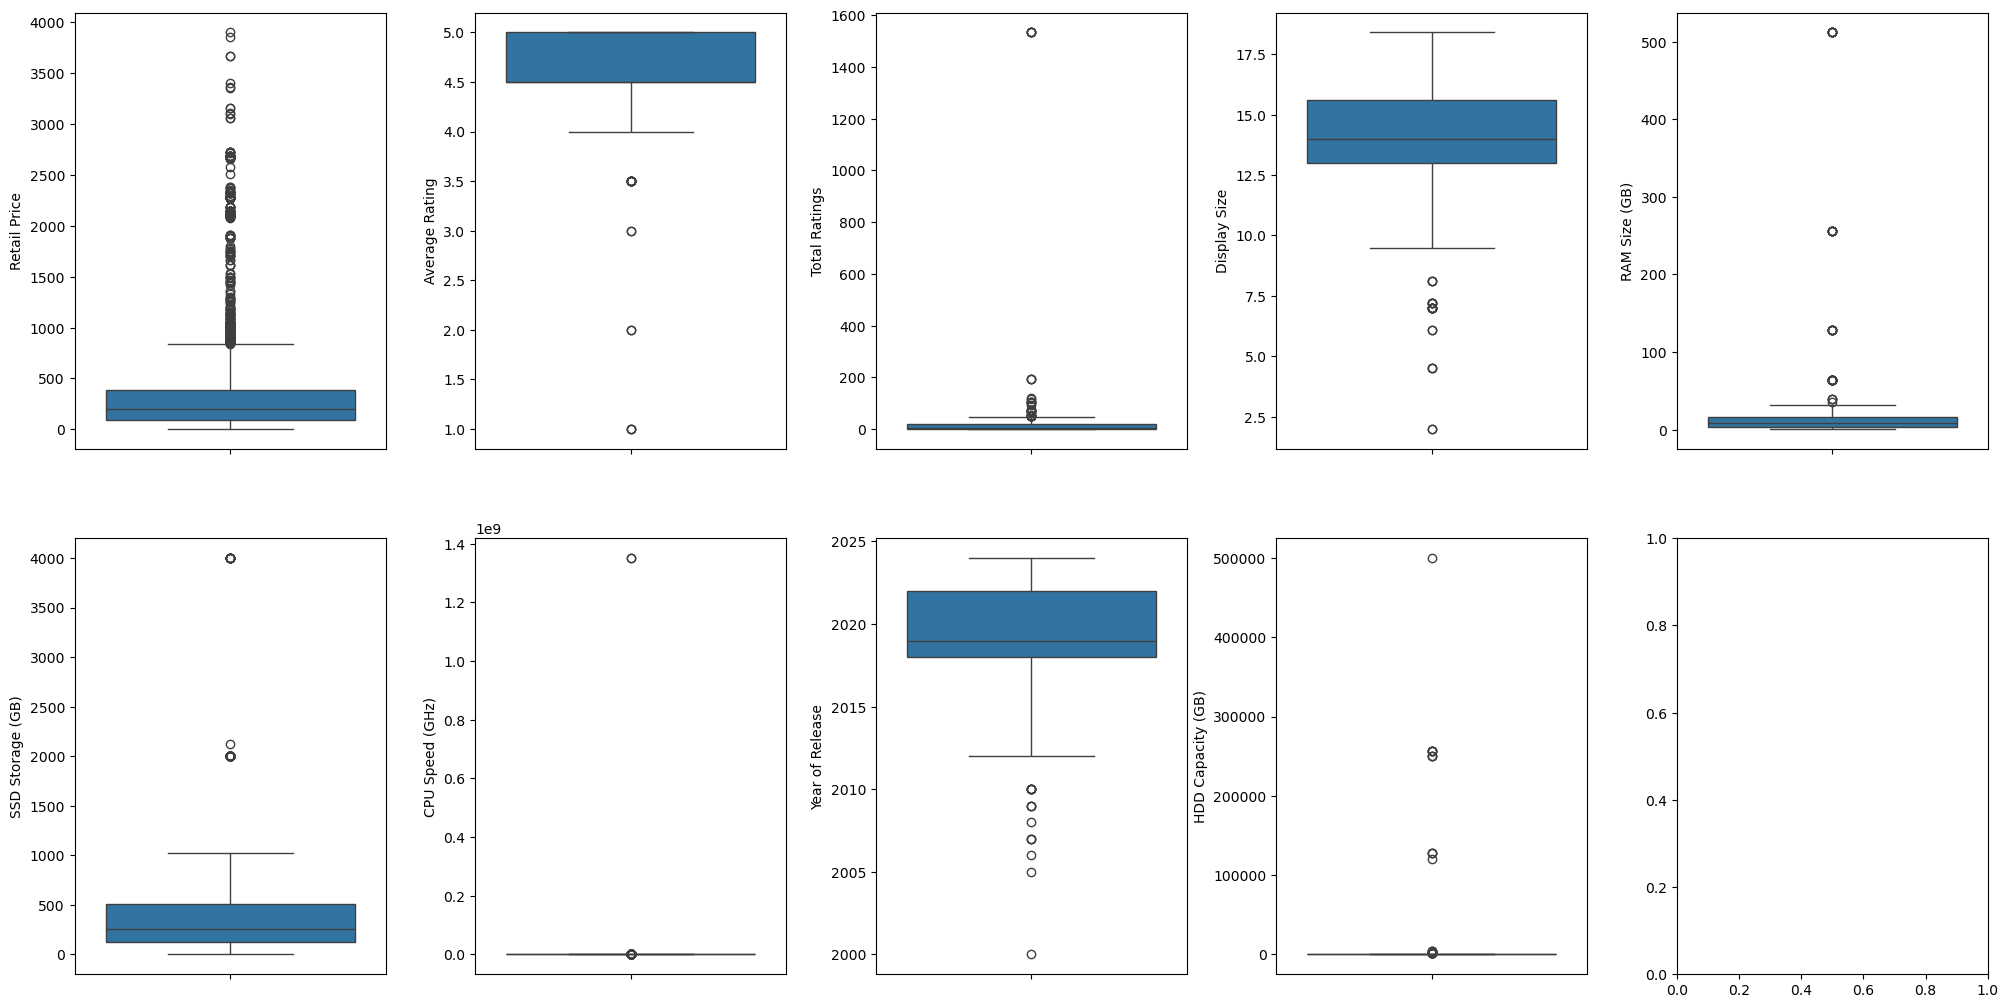

In [9]:
# Checking outliers
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    if df[k].dtype == 'float64':
        sns.boxplot(y=k, data=df, ax=axs[index])
        index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

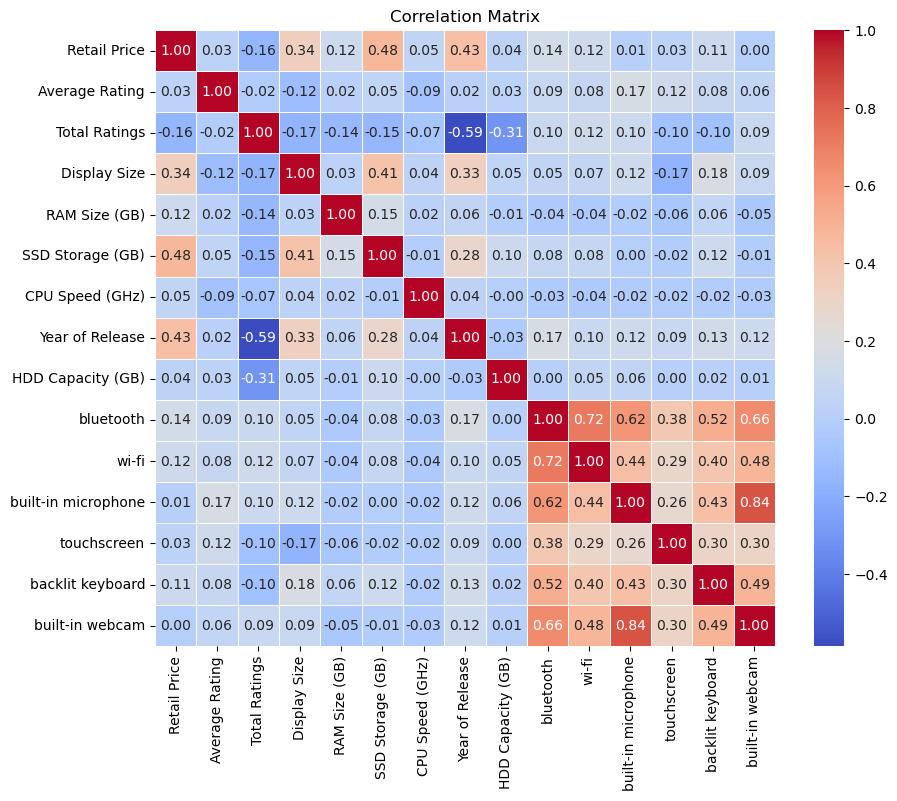

In [10]:
# Select only numeric and bool columns from the dataframe to see correlation
numeric_df = df.select_dtypes(include=['float64', 'int64', 'bool'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# **4. Data Pre Processing**

4.1 **Dropping unnecessay columns and filling missing values**

In [13]:
columns_to_drop = [
    'Average Rating', 'Total Ratings', 'Country of Manufacture', 'Color',
    'Year of Release', 'Display Size', 'CPU Speed (GHz)',
    'Max Resolution', 'Storage Type', 'HDD Capacity (GB)', 'bluetooth',
    'wi-fi', 'built-in microphone', 'backlit keyboard', 'built-in webcam',
    'Product Condition'
]
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')
print("\nData Shape after Dropping Columns:", df_cleaned.shape)

# Filling missing categorical data with mode
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_columns:
    most_frequent = df_cleaned[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].fillna(most_frequent)

# Filling missing numerical data with median
numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].median())

# Verify no missing values remain
print("\nVerify missing values after cleaning:")
print(df_cleaned.isnull().sum().sum())


Data Shape after Dropping Columns: (6492, 10)

Verify missing values after cleaning:
0


**4.2 Feature Engineering**

In [15]:
df_cleaned['SSD_x_RAM'] = df_cleaned['SSD Storage (GB)'] * df_cleaned['RAM Size (GB)']
df_cleaned['SSD_x_CPU'] = df_cleaned['SSD Storage (GB)'] * df_cleaned['CPU'].apply(lambda x: len(str(x)))
df_cleaned['CPU_x_RAM'] = df_cleaned['CPU'].apply(lambda x: len(str(x))) * df_cleaned['RAM Size (GB)']

print("\nData Shape after Feature Engineering:", df_cleaned.shape)


Data Shape after Feature Engineering: (6492, 13)


**Exporting CSV After pre-procesing**

# **XGB Model**

***Data Processing***

In [20]:
# For XGBoost, keep original categorical variables (without One-Hot Encoding)
# Re-prepare data for XGBoost
df_xgb = df_cleaned.copy()

## converting booleans to numeric
z

# Encode categorical variables as 'category' dtype
categorical_columns = df_xgb.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_xgb[col] = df_xgb[col].astype('category')

X_xgb = df_xgb.drop('Retail Price', axis=1)
y_xgb = df_xgb['Retail Price']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

print("\nTrain-Test Split Completed.")


Train-Test Split Completed.


In [21]:
# Scale numerical features for XGBoost
scaler = StandardScaler()
numeric_features_xgb = X_xgb.select_dtypes(include=['float64', 'int64']).columns

X_train_xgb_scaled = X_train_xgb.copy()
X_test_xgb_scaled = X_test_xgb.copy()

X_train_xgb_scaled[numeric_features_xgb] = scaler.fit_transform(X_train_xgb[numeric_features_xgb])
X_test_xgb_scaled[numeric_features_xgb] = scaler.transform(X_test_xgb[numeric_features_xgb])

print("\nFeature Scaling Completed for XGBoost.")


Feature Scaling Completed for XGBoost.


**Baseline Model Training**

In [23]:
print("\nTraining XGBoost Regressor...")
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    enable_categorical=True,
    random_state=42
)

xgb_model.fit(X_train_xgb_scaled, y_train_xgb)

# Predictions
y_pred_train_xgb = xgb_model.predict(X_train_xgb_scaled)
y_pred_test_xgb = xgb_model.predict(X_test_xgb_scaled)


Training XGBoost Regressor...


In [24]:
print("\nXGBoost Regressor Evaluation:")
calculate_metrics(y_train_xgb, y_pred_train_xgb, "Training")
calculate_metrics(y_test_xgb, y_pred_test_xgb, "Testing")


XGBoost Regressor Evaluation:
Training Metrics:
  MSE: 18892.5243
  RMSE: 137.4501
  MAE: 54.6439
  R²: 0.8809

Testing Metrics:
  MSE: 43776.2198
  RMSE: 209.2277
  MAE: 92.0589
  R²: 0.7421



(43776.219759505504, 209.2276744589623, 92.05885973075063, 0.7420553839152645)

**Model Evaluation**

In [26]:
# Check predictions and actual values
print("Predictions (first 10):", y_pred_test_xgb[:10])  
print("Actual values (first 10):", y_test_xgb.values[:10]) 

Predictions (first 10): [ 427.07034  133.85992  133.85992 1029.3076   133.85992  133.85992
  507.0695   219.24367  206.62808  334.50955]
Actual values (first 10): [ 465.2    21.8   333.92 1030.1   104.43  104.68  326.28  721.83  149.95
  352.61]


In [27]:
# Cross- validation:

# Setting a random seed
np.random.seed(42)

scores_R2 = cross_val_score(xgb_model, X_xgb, y_xgb, cv=10, scoring='r2')

# Printing R2 cross-validation scores
print('R2 Cross-validation scores: {}'.format(scores_R2))
print('Average R2 Cross-validation score: {}'.format(scores_R2.mean()))

R2 Cross-validation scores: [0.72042074 0.61319    0.76437378 0.70692371 0.47157231 0.51865053
 0.82399924 0.87537485 0.74154349 0.93976199]
Average R2 Cross-validation score: 0.717581065648973



Generating XGBoost Model Plots...


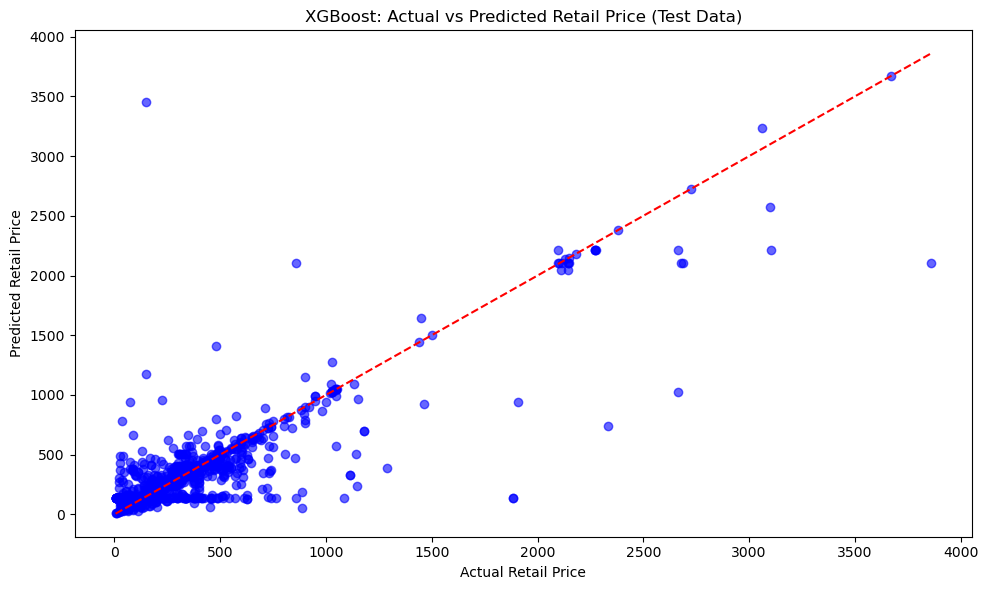

In [28]:
print("\nGenerating XGBoost Model Plots...")

# Actual vs Predicted
plot_actual_vs_predicted(
    y_test_xgb,
    y_pred_test_xgb,
    title="XGBoost: Actual vs Predicted Retail Price (Test Data)"
)

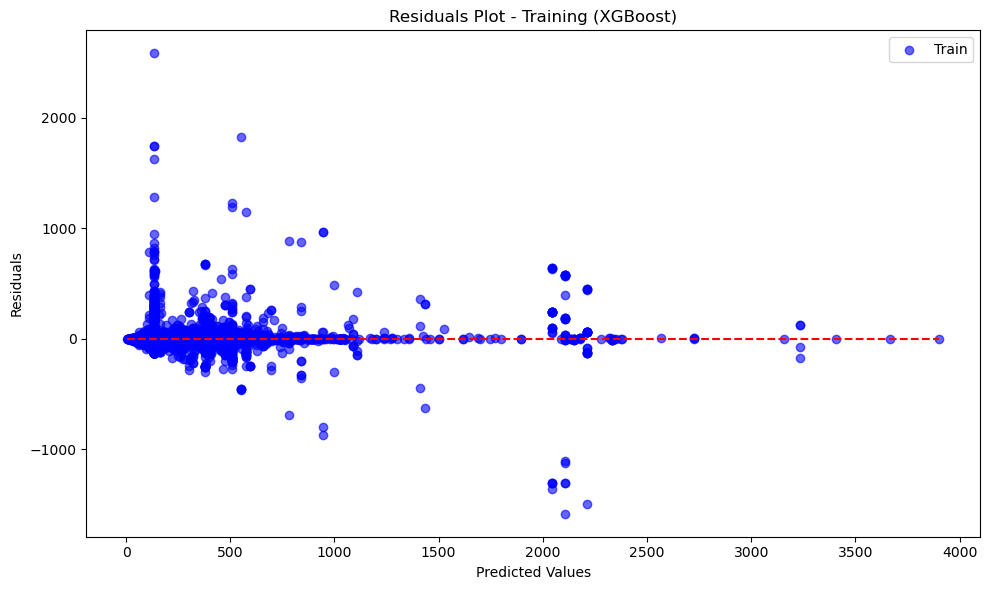

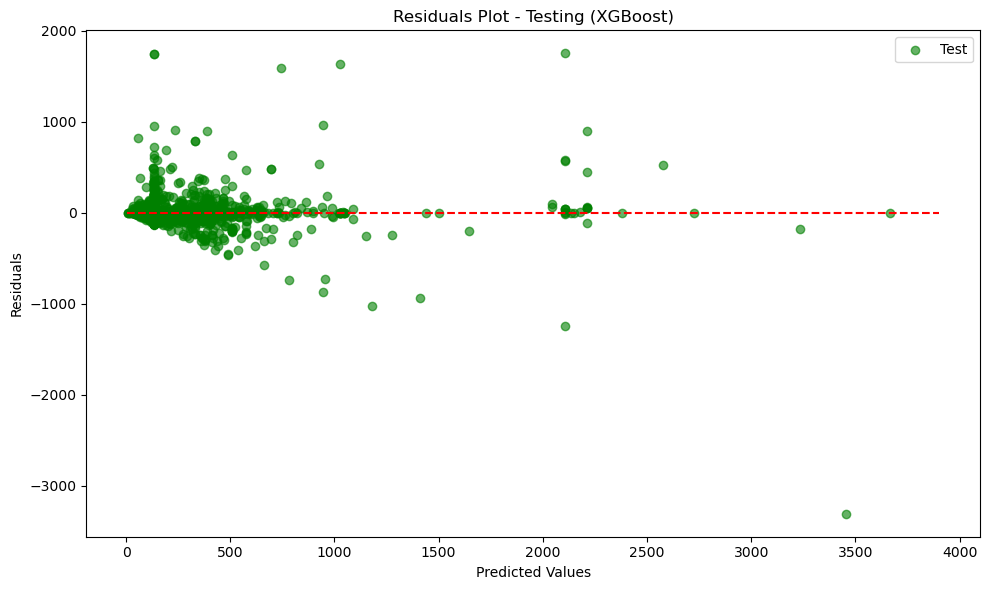

In [29]:
# Residuals
plot_residuals(
    y_pred_train_xgb,
    y_train_xgb,
    y_pred_test_xgb,
    y_test_xgb,
    model_name="XGBoost"
)

C:\Users\56932\AppData\Local\Temp\ipykernel_18268\4193702931.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


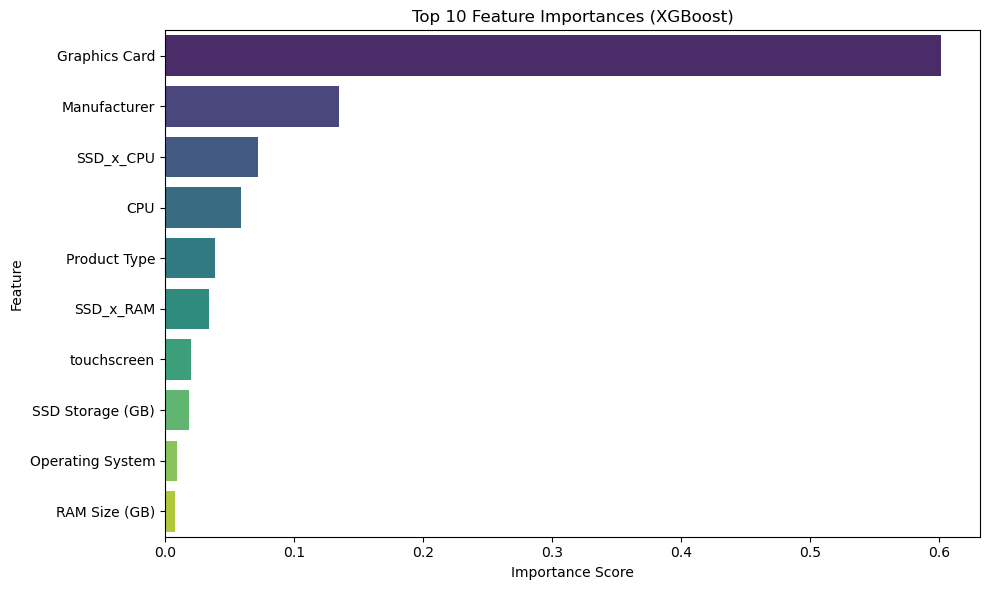

In [30]:
# Feature Importance
best_xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train_xgb_scaled.columns).sort_values(ascending=False)
plot_feature_importance(
    best_xgb_importances,
    best_xgb_importances.index,
    top_n=10,
    model_name="XGBoost"
)

**Model Optimization**

In [32]:
print("\nTuning XGBoost Hyperparameters using RandomizedSearchCV...")
xgb_param_dist = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [75, 100, 200, 300, 400]
}

rand_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', enable_categorical=True, random_state=42),
    param_distributions=xgb_param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rand_search_xgb.fit(X_train_xgb_scaled, y_train_xgb)

# Best parameters
best_xgb_model = rand_search_xgb.best_estimator_
print("Best XGBoost Parameters:", rand_search_xgb.best_params_)

# Predictions with Best XGBoost Model
y_pred_train_best_xgb = best_xgb_model.predict(X_train_xgb_scaled)
y_pred_test_best_xgb = best_xgb_model.predict(X_test_xgb_scaled)

# Evaluation of Best XGBoost Model
print("\nBest XGBoost Model Evaluation:")
calculate_metrics(y_train_xgb, y_pred_train_best_xgb, "Training")
calculate_metrics(y_test_xgb, y_pred_test_best_xgb, "Testing")


Tuning XGBoost Hyperparameters using RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2}

Best XGBoost Model Evaluation:
Training Metrics:
  MSE: 20308.3182
  RMSE: 142.5073
  MAE: 63.4310
  R²: 0.8720

Testing Metrics:
  MSE: 41279.8016
  RMSE: 203.1743
  MAE: 95.4879
  R²: 0.7568



(41279.80163068572, 203.1743134126106, 95.48785513540155, 0.7567651423037917)

# **Random Forest**

**Data Processing**

In [36]:
df_cleaned['CPU_RAM_Interaction'] = df_cleaned['CPU Brand'] + "_" + df_cleaned['RAM Size (GB)'].astype(str)
df_cleaned['CPU_SSD_Interaction'] = df_cleaned['CPU Brand'] + "_" + df_cleaned['SSD Storage (GB)'].astype(str)

In [37]:
categorical_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()

# One hot encoding is applied to
X_rf = pd.get_dummies(df_cleaned.drop('Retail Price', axis=1), columns=categorical_columns, drop_first=True)
y_rf = df_cleaned['Retail Price']

print("\nFeature Matrix Shape after Encoding (Random Forest):", X_rf.shape)


Feature Matrix Shape after Encoding (Random Forest): (6492, 939)


In [38]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)
# Align the train and test datasets to ensure they have the same one-hot encoded columns
X_train_rf, X_test_rft = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

**Base model training**

In [40]:
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_train_rf = rf_model.predict(X_train_rf)
y_pred_test_rf = rf_model.predict(X_test_rf)

# Evaluation
print("\nRandom Forest Regressor Evaluation:")
calculate_metrics(y_train_rf, y_pred_train_rf, "Training")
calculate_metrics(y_test_rf, y_pred_test_rf, "Testing")


Training Random Forest Regressor...

Random Forest Regressor Evaluation:
Training Metrics:
  MSE: 20924.2860
  RMSE: 144.6523
  MAE: 63.8104
  R²: 0.8681

Testing Metrics:
  MSE: 33017.5093
  RMSE: 181.7072
  MAE: 89.5161
  R²: 0.8054



(33017.5093287289, 181.70720769614204, 89.51610755125238, 0.8054494240329226)

**Model optimization**

In [42]:
print("Tuning Random Forest Hyperparameters using GridSearchCV...")
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

grid_search_rf.fit(X_train_rf, y_train_rf)

# Best parameters
best_rf_model = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# Predictions with Best Random Forest Model
y_pred_train_best_rf = best_rf_model.predict(X_train_rf)
y_pred_test_best_rf = best_rf_model.predict(X_test_rf)

# Evaluation of Best Random Forest Model
print("\nBest Random Forest Model Evaluation:")
calculate_metrics(y_train_rf, y_pred_train_best_rf, "Training")
calculate_metrics(y_test_rf, y_pred_test_best_rf, "Testing")


Tuning Random Forest Hyperparameters using GridSearchCV...
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

Best Random Forest Model Evaluation:
Training Metrics:
  MSE: 18643.0479
  RMSE: 136.5395
  MAE: 50.2949
  R²: 0.8825

Testing Metrics:
  MSE: 31596.4881
  RMSE: 177.7540
  MAE: 84.4140
  R²: 0.8138



(31596.488085207213, 177.7540100397378, 84.41399228964656, 0.8138225723111923)


Generating Best Random Forest Model Plots...


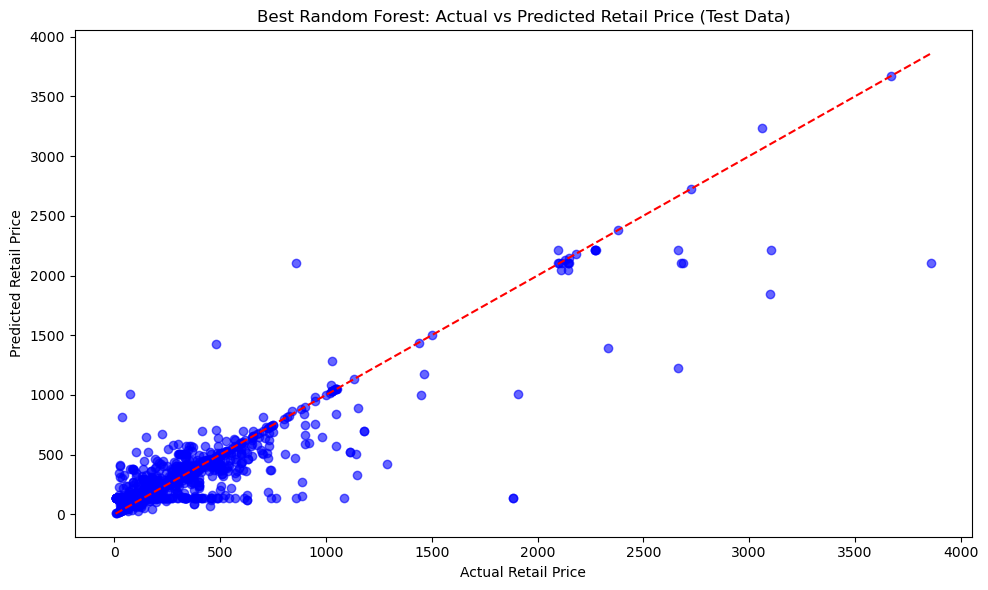

In [43]:
print("\nGenerating Best Random Forest Model Plots...")

# Actual vs Predicted
plot_actual_vs_predicted(
    y_test_rf,
    y_pred_test_best_rf,
    title="Best Random Forest: Actual vs Predicted Retail Price (Test Data)"
)

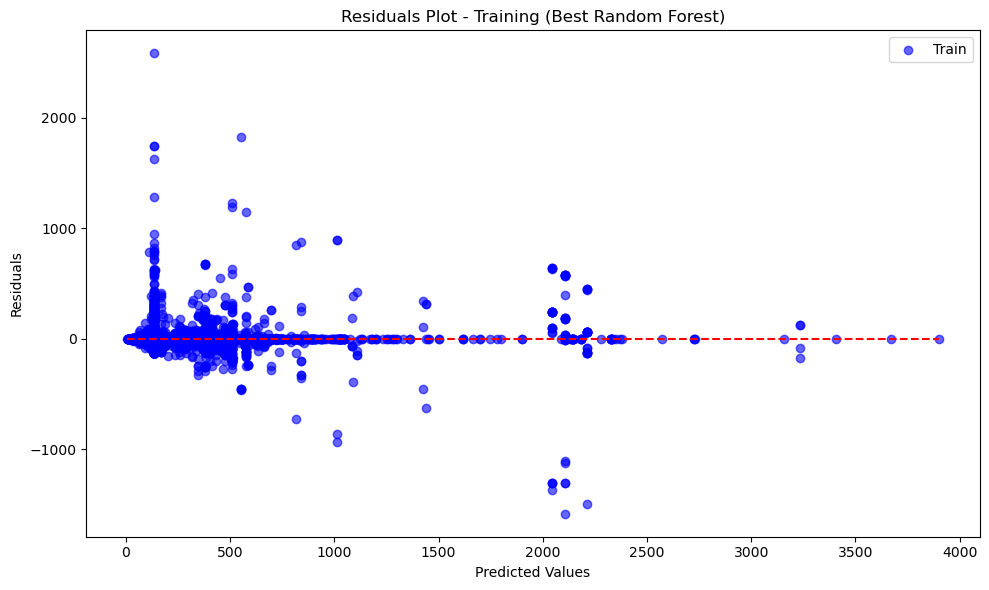

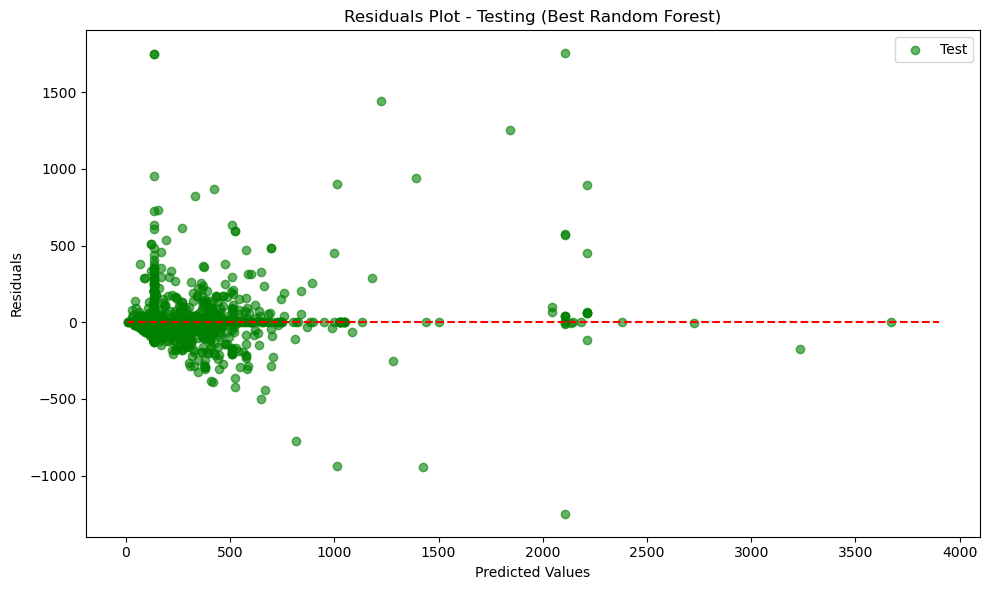

In [44]:
# Residuals
plot_residuals(
    y_pred_train_best_rf,
    y_train_rf,
    y_pred_test_best_rf,
    y_test_rf,
    model_name="Best Random Forest"
)



C:\Users\56932\AppData\Local\Temp\ipykernel_18268\4193702931.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


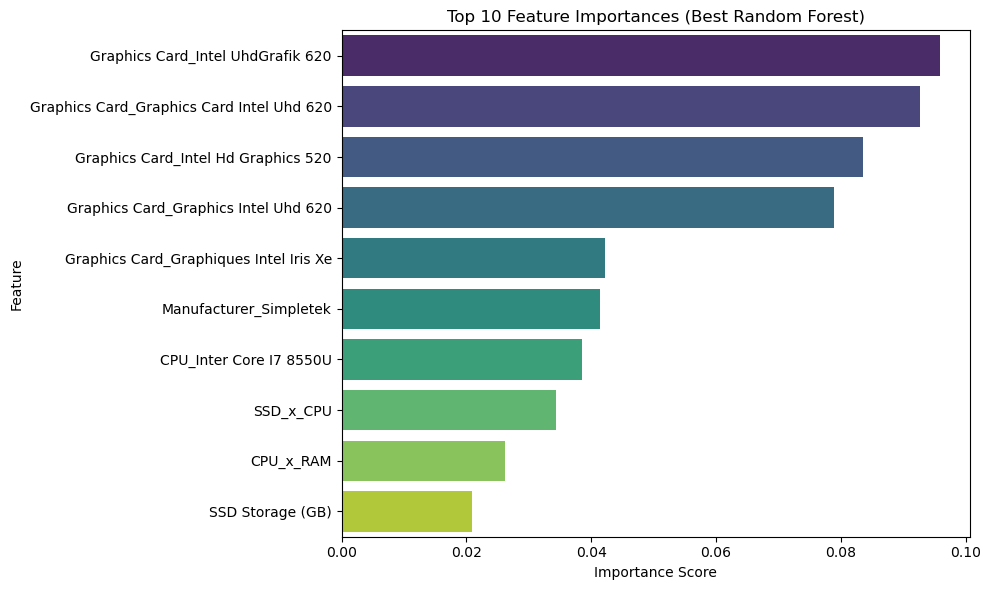

In [45]:
# Feature Importance
best_rf_importances = pd.Series(best_rf_model.feature_importances_, index=X_rf.columns).sort_values(ascending=False)
plot_feature_importance(
    best_rf_importances,
    best_rf_importances.index,
    top_n=10,
    model_name="Best Random Forest"
)

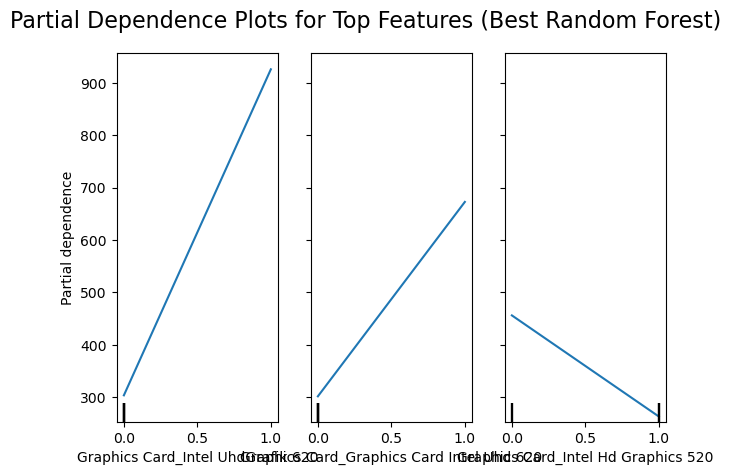

In [46]:
# Partial Dependence Plots for Top 3 Features
top_3_features_best_rf = best_rf_importances.index[:3].tolist()
plot_partial_dependence_custom(
    best_model=best_rf_model,
    X_train=X_train_rf,
    top_features=top_3_features_best_rf,
    model_name="Best Random Forest"
)

In [79]:
def calculate_metrics(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{model_name} Model Performance:")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")
    print(f"MAE: {mae}")
    return rmse, r2, mae

# XGBoost Model Metrics
print("\nEvaluating XGBoost Model:")
xgb_train_metrics = calculate_metrics(y_train_xgb, y_pred_train_xgb, "XGBoost Training")
xgb_test_metrics = calculate_metrics(y_test_xgb, y_pred_test_xgb, "XGBoost Testing")

# Random Forest Model Metrics
print("\nEvaluating Random Forest Model:")
rf_train_metrics = calculate_metrics(y_train_rf, y_pred_train_rf, "Random Forest Training")
rf_test_metrics = calculate_metrics(y_test_rf, y_pred_test_rf, "Random Forest Testing")

# Comparing Models
def compare_models(xgb_metrics, rf_metrics, dataset_name):
    print(f"\nComparison of Models on {dataset_name}:")
    print(f"{'Metric':<20} {'XGBoost':<20} {'Random Forest':<20}")
    metrics_labels = ["RMSE", "R-squared", "MAE"]
    for i, metric in enumerate(metrics_labels):
        print(f"{metric:<20} {xgb_metrics[i]:<20.4f} {rf_metrics[i]:<20.4f}")

# Compare training performance
compare_models(xgb_train_metrics, rf_train_metrics, "Training Data")

# Compare testing performance
compare_models(xgb_test_metrics, rf_test_metrics, "Testing Data")

# Final Model Recommendation!!
def recommend_final_model(xgb_metrics, rf_metrics):
    print("\nFinal Model Recommendation:")
    
    if xgb_metrics[0] < rf_metrics[0] and xgb_metrics[1] > rf_metrics[1]:
        print("XGBoost is the recommended model, with better overall performance on the test set:")
        print(f"RMSE: {xgb_metrics[0]:.4f}, R-squared: {xgb_metrics[1]:.4f}, MAE: {xgb_metrics[2]:.4f}")
    elif rf_metrics[0] < xgb_metrics[0] and rf_metrics[1] > xgb_metrics[1]:
        print("Random Forest is the recommended model, with better overall performance on the test set:")
        print(f"RMSE: {rf_metrics[0]:.4f}, R-squared: {rf_metrics[1]:.4f}, MAE: {rf_metrics[2]:.4f}")
    else:
        print("Both models show similar performance.")

recommend_final_model(xgb_test_metrics, rf_test_metrics)



Evaluating XGBoost Model:

XGBoost Training Model Performance:
RMSE: 137.4500791955811
R-squared: 0.8809441303957504
MAE: 54.64393946762055

XGBoost Testing Model Performance:
RMSE: 209.2276744589623
R-squared: 0.7420553839152645
MAE: 92.05885973075063

Evaluating Random Forest Model:

Random Forest Training Model Performance:
RMSE: 144.65229333684616
R-squared: 0.8681404863635638
MAE: 63.810363591145745

Random Forest Testing Model Performance:
RMSE: 181.70720769614204
R-squared: 0.8054494240329226
MAE: 89.51610755125238

Comparison of Models on Training Data:
Metric               XGBoost              Random Forest       
RMSE                 137.4501             144.6523            
R-squared            0.8809               0.8681              
MAE                  54.6439              63.8104             

Comparison of Models on Testing Data:
Metric               XGBoost              Random Forest       
RMSE                 209.2277             181.7072            
R-squared     

C:\Users\56932\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\56932\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\56932\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\56932\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

# **END Code.**